policy


Epoch 3:
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97

Final Policy:
Final Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Final Values:
Final Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97


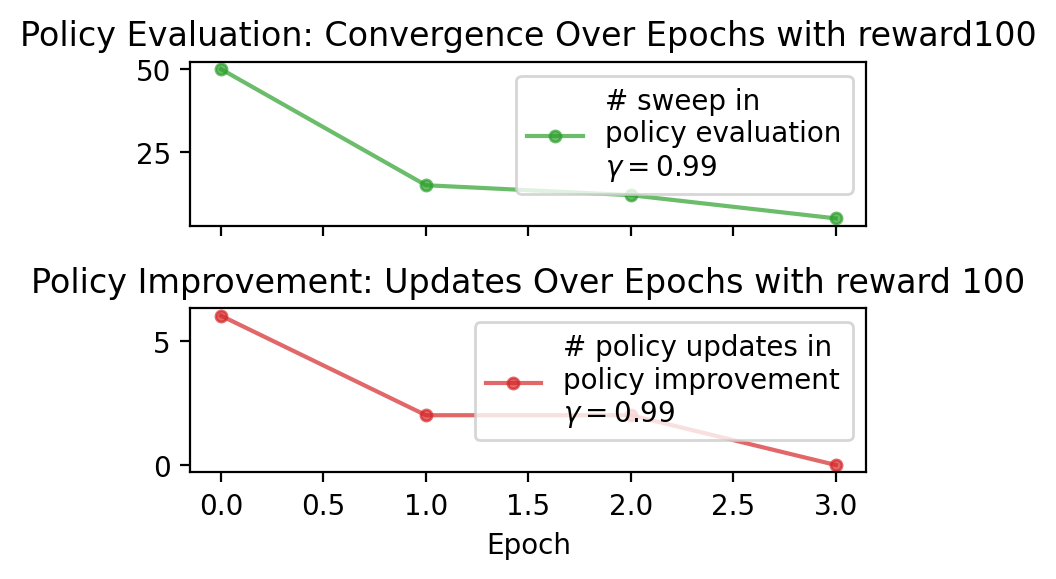


Epoch 3:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93

Final Policy:
Final Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Final Values:
Final Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93


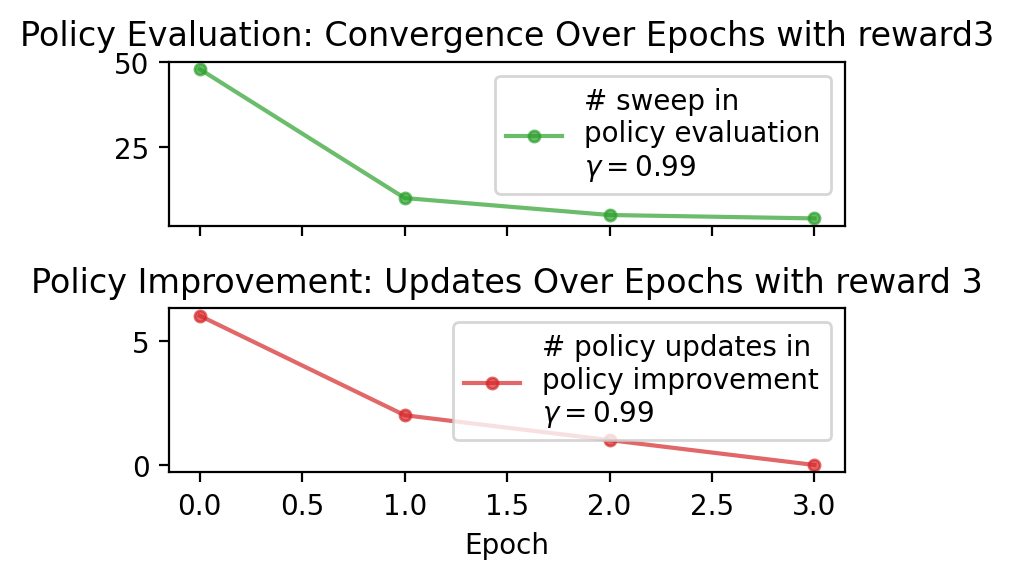


Epoch 3:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93

Final Policy:
Final Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Final Values:
Final Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93


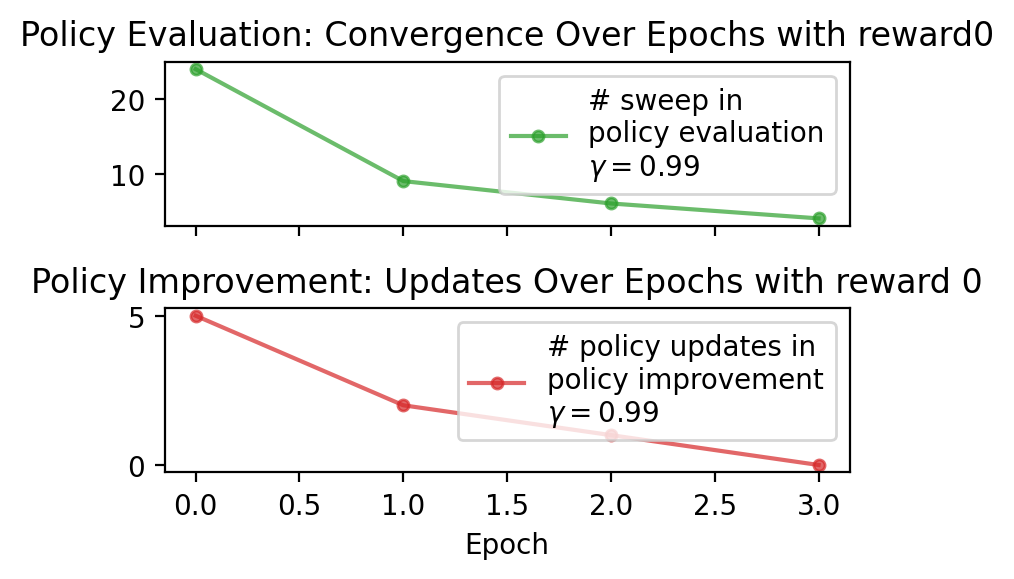


Epoch 3:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93

Final Policy:
Final Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
--- --- ---
--- --- ---
--- --- ---
Final Values:
Final Values Grid:
--- --- ---
--- --- ---
--- --- ---

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93


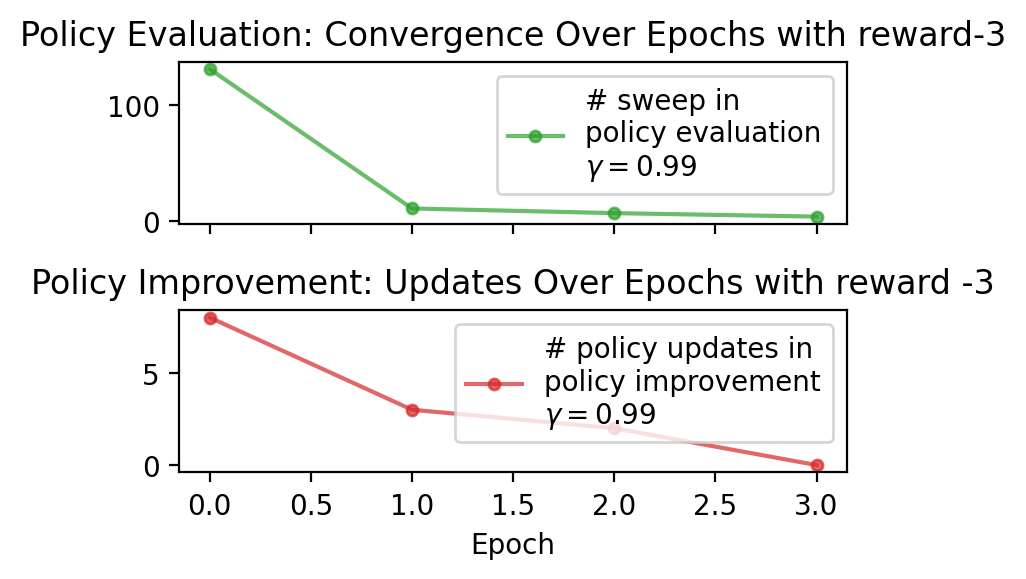

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid world setup and transition model
def create_grid_world(r):
    # Reward function for the grid world
    reward_function = np.full(9, -1)  # All non-terminal states have a reward of -1
    reward_function[0] = r # Upper-left corner terminal state
    reward_function[2] = 10   # Upper-right corner terminal state

    # Transition model
    transition_model = np.zeros((9, 4, 9))  # 9 states, 4 actions (Up, Down, Left, Right)
    
    # Action indices: Up = 0, Down = 1, Left = 2, Right = 3
    # Define the state transitions, with 80% probability to go in the intended direction
    directions = [(-3, 0), (3, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    for state in range(9):
        if state == 0 or state == 2:  # Terminal states
            continue
        for action in range(4):
            intended_direction = directions[action]
            intended_state = state + intended_direction[0] + intended_direction[1]
            
            # Ensure the state is within bounds (0-8) and doesn't fall off the grid
            if intended_state < 0 or intended_state >= 9:
                intended_state = state  # Wall collision, stay in the same state
            
            # 80% to move in the intended direction
            transition_model[state, action, intended_state] += 0.8

            # For the right-angle directions (10% probability each)
            for perpendicular_action in [(action + 1) % 4, (action + 3) % 4]:
                perpendicular_direction = directions[perpendicular_action]
                perpendicular_state = state + perpendicular_direction[0] + perpendicular_direction[1]

                # Ensure perpendicular state is within bounds
                if perpendicular_state < 0 or perpendicular_state >= 9:
                    perpendicular_state = state  # Wall collision, stay in the same state
                
                transition_model[state, action, perpendicular_state] += 0.1

    return reward_function, transition_model

class PolicyIteration:
    def __init__(self, reward_function, transition_model, gamma, init_policy=None):
        self.num_states = len(reward_function)
        self.num_actions = len(transition_model[0])  # Number of actions
        self.reward_function = np.nan_to_num(reward_function)

        self.transition_model = transition_model
        self.gamma = gamma

        self.values = np.zeros(self.num_states)
        if init_policy is None:
            self.policy = np.random.randint(0, self.num_actions, self.num_states)
        else:
            self.policy = init_policy

    def one_policy_evaluation(self):
        delta = 0
        for s in range(self.num_states):
            temp = self.values[s]
            a = self.policy[s]
            p = self.transition_model[s, a]
            self.values[s] = self.reward_function[s] + self.gamma * np.sum(p * self.values)
            delta = max(delta, abs(temp - self.values[s]))
        return delta

    def run_policy_evaluation(self, tol=1e-3):
        epoch = 0
        delta = self.one_policy_evaluation()
        delta_history = [delta]
        while epoch < 500:
            delta = self.one_policy_evaluation()
            delta_history.append(delta)
            if delta < tol:
                break
        return len(delta_history)

    def run_policy_improvement(self):
        update_policy_count = 0
        for s in range(self.num_states):
            temp = self.policy[s]
            v_list = np.zeros(self.num_actions)
            for a in range(self.num_actions):
                p = self.transition_model[s, a]
                v_list[a] = np.sum(p * self.values)
            self.policy[s] = np.argmax(v_list)
            if temp != self.policy[s]:
                update_policy_count += 1
        return update_policy_count

    def train(self, tol=1e-3, plot=True):
        epoch = 0
        eval_count = self.run_policy_evaluation(tol=tol)
        eval_count_history = [eval_count]
        policy_change = self.run_policy_improvement()
        policy_change_history = [policy_change]

        while epoch < 500:
            epoch += 1
            new_eval_count = self.run_policy_evaluation(tol)
            new_policy_change = self.run_policy_improvement()
            eval_count_history.append(new_eval_count)
            policy_change_history.append(new_policy_change)

            # Print the last few policies and values as grid
            if epoch % 10 == 0 or new_policy_change == 0:  # Print every 10 epochs
                print(f"\nEpoch {epoch}:")
                self.print_grid(self.policy, "Policy")
                self.print_grid(self.values, "Values")

            if new_policy_change == 0:
                break

        print(f'\nFinal Policy:')
        self.print_grid(self.policy, "Final Policy")
        print(f'Final Values:')
        self.print_grid(self.values, "Final Values")

        if plot is True:
            fig, axes = plt.subplots(2, 1, figsize=(4, 3), sharex='all', dpi=200)

            # Plot for policy evaluation
            axes[0].plot(np.arange(len(eval_count_history)), eval_count_history, marker='o', markersize=4, alpha=0.7,
                         color='#2ca02c', label='# sweep in \npolicy evaluation\n' + r'$\gamma =$' + f'{self.gamma}')
            axes[0].legend()
            axes[0].set_title(f"Policy Evaluation: Convergence Over Epochs with reward{r}")

            # Plot for policy improvement
            axes[1].plot(np.arange(len(policy_change_history)), policy_change_history, marker='o',
                         markersize=4, alpha=0.7, color='#d62728',
                         label='# policy updates in \npolicy improvement\n' + r'$\gamma =$' + f'{self.gamma}')
            axes[1].set_xlabel('Epoch')
            axes[1].set_title(f"Policy Improvement: Updates Over Epochs with reward {r}")
            axes[1].legend()

            plt.tight_layout()
            plt.show()

    def print_grid(self, data, title=""):
        """ Helper function to print the grid """
        grid_size = 3  # 3x3 grid
        arrows = ['↑', '↓', '←', '→']  # Mapping actions to arrows
        grid = np.full((grid_size, grid_size), '---', dtype=object)  # Placeholder for policy grid
        value_grid = np.full((grid_size, grid_size), '---', dtype=object)  # Placeholder for value grid

        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                if data is self.policy:
                    if idx != 0 and idx != 2:  # Skip terminal states
                        grid[i, j] = arrows[data[idx]]  # Policy (actions)
                    else:
                        grid[i, j] = 'T'  # Terminal states marked as 'T'
                elif data is self.values:
                    if idx != 0 and idx != 2:  # Skip terminal states
                        value_grid[i, j] = f"{data[idx]:.2f}"  # Values
                    else:
                        value_grid[i, j] = f"{data[idx]:.2f}"  # Terminal state values

        print(f"{title} Grid:")
        for i in range(grid_size):
            print(' '.join(grid[i]))

        print("\nValues Grid:")
        for i in range(grid_size):
            print(' '.join(value_grid[i]))


# Example usage of PolicyIteration
r_values = [100, 3, 0, -3]
for r in r_values:
    reward_function, transition_model = create_grid_world(r)
    policy_iteration = PolicyIteration(reward_function, transition_model, gamma=0.99)
    policy_iteration.train()


value

Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97
Optimal Policy Grid:
T ← T
↑ ↓ ↓
↑ ↓ ↑


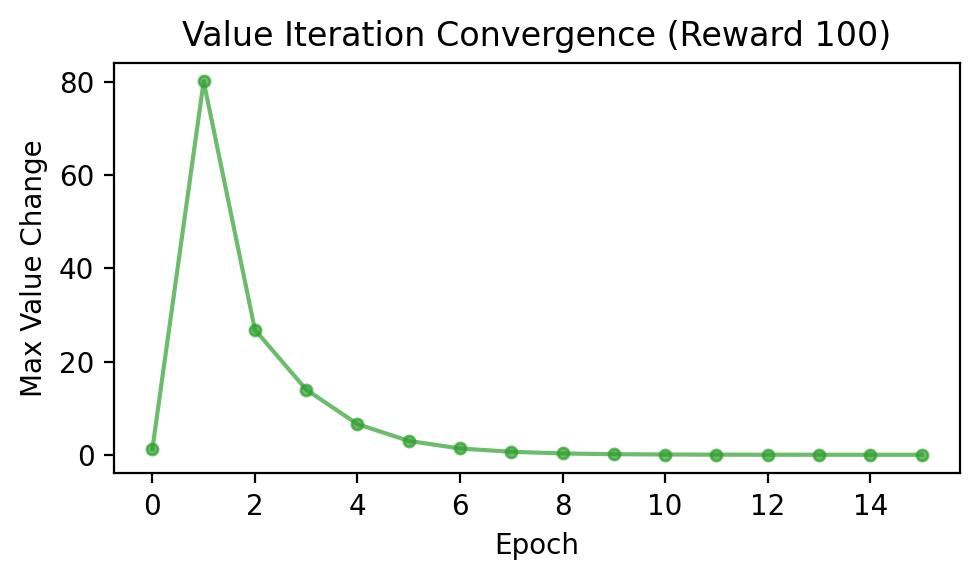

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93
Optimal Policy Grid:
T → T
↓ → ↑
↑ ↑ ↑


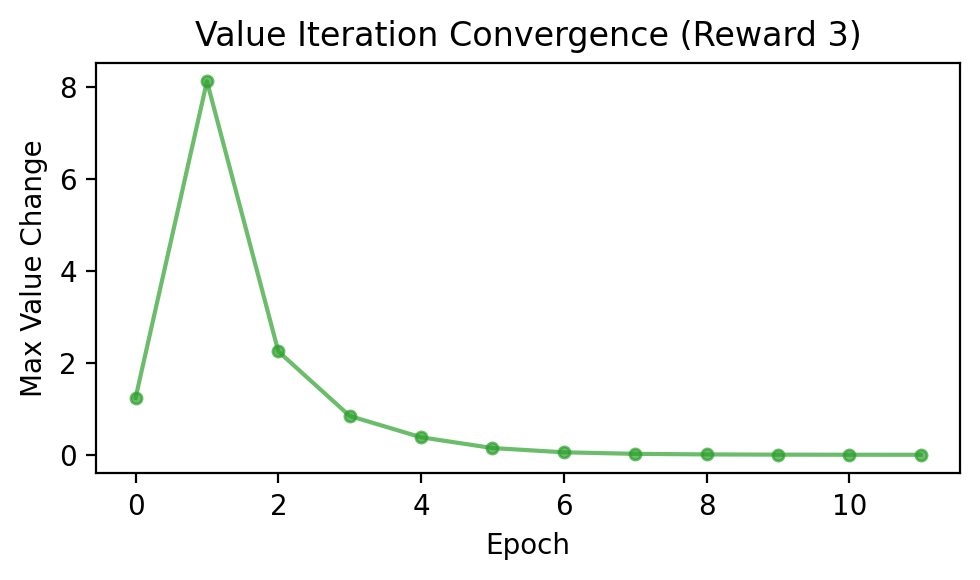

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93
Optimal Policy Grid:
T → T
↓ → ↑
↑ ↑ ↑


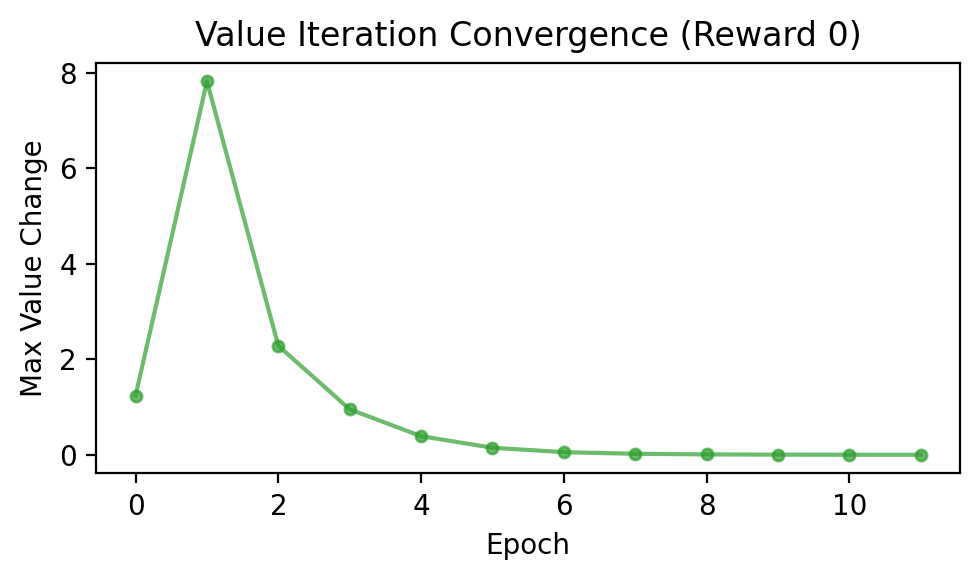

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93
Optimal Policy Grid:
T → T
↓ → ↑
↑ ↑ ↑


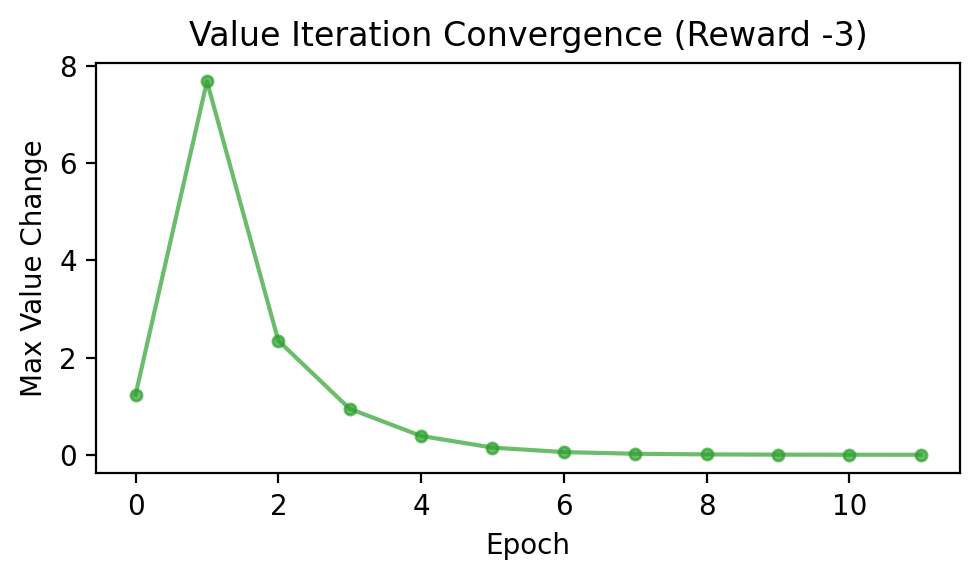

In [21]:
class ValueIteration:
    def __init__(self, reward_function, transition_model, gamma, init_values=None):
        self.num_states = len(reward_function)
        self.num_actions = len(transition_model[0])  # Number of actions
        self.reward_function = np.nan_to_num(reward_function)
        self.transition_model = transition_model
        self.gamma = gamma

        self.values = np.zeros(self.num_states)
        if init_values is not None:
            self.values = init_values  # Optional: Initialize with custom values
        self.policy = np.zeros(self.num_states, dtype=int)  # Optimal policy (actions)

    def one_value_iteration(self):
        delta = 0
        for s in range(self.num_states):
            if s == 0 or s == 2:  # Skip terminal states (no value update)
                continue
            temp = self.values[s]
            value_list = np.zeros(self.num_actions)
            for a in range(self.num_actions):
                p = self.transition_model[s, a]
                value_list[a] = np.sum(p * self.values)
            self.values[s] = self.reward_function[s] + self.gamma * np.max(value_list)
            self.policy[s] = np.argmax(value_list)  # Track the action with max value
            delta = max(delta, abs(temp - self.values[s]))

        # Manually set terminal state values
        self.values[0] = self.reward_function[0]  # Top-left corner
        self.values[2] = self.reward_function[2]  # Top-right corner

        return delta

    def run_value_iteration(self, tol=1e-3):
        epoch = 0
        delta = self.one_value_iteration()
        delta_history = [delta]
        while epoch < 500:
            delta = self.one_value_iteration()
            delta_history.append(delta)
            if delta < tol:
                break
            epoch += 1
        return delta_history

    def print_values_grid(self):
        """ Helper function to print the values grid """
        grid_size = 3  # 3x3 grid
        value_grid = np.full((grid_size, grid_size), '---', dtype=object)  # Placeholder for values

        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                if idx == 0 or idx == 2:  # Terminal states
                    value_grid[i, j] = f"{self.values[idx]:.2f}"  # Fixed terminal values
                else:
                    value_grid[i, j] = f"{self.values[idx]:.2f}"

        print("Values Grid:")
        for i in range(grid_size):
            print(' '.join(value_grid[i]))

    def print_optimal_policy(self):
        """ Helper function to print the optimal policy """
        grid_size = 3  # 3x3 grid
        action_map = ['↑', '←', '↓', '→']  # Mapping of actions (0 = ↑, 1 = ←, 2 = ↓, 3 = →)
        policy_grid = np.full((grid_size, grid_size), '---', dtype=object)

        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                if idx == 0 or idx == 2:  # Terminal states, no action
                    policy_grid[i, j] = 'T'  # Terminal state marked as T
                else:
                    policy_grid[i, j] = action_map[self.policy[idx]]  # Optimal action

        print("Optimal Policy Grid:")
        for i in range(grid_size):
            print(' '.join(policy_grid[i]))

    def plot_convergence(self, delta_history, r):
        """ Function to plot convergence """
        plt.figure(figsize=(5, 3), dpi=200)
        plt.plot(np.arange(len(delta_history)), delta_history, marker='o', markersize=4, alpha=0.7, color='#2ca02c')
        plt.title(f"Value Iteration Convergence (Reward {r})")
        plt.xlabel("Epoch")
        plt.ylabel("Max Value Change")
        plt.tight_layout()
        plt.show()

# Example usage of ValueIteration
r_values = [100, 3, 0, -3]
for r in r_values:
    reward_function, transition_model = create_grid_world(r)
    value_iteration = ValueIteration(reward_function, transition_model, gamma=0.99)
    delta_history = value_iteration.run_value_iteration()
    value_iteration.print_values_grid()
    value_iteration.print_optimal_policy()
    value_iteration.plot_convergence(delta_history, r)
